<a href="https://colab.research.google.com/github/mjsmagalhaes/examples-datascience/blob/main/restaurant_reviews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Restaurant Review Analysis

A notebook investigating a restaurant review dataset from kaggle (https://www.kaggle.com/bulentsiyah/restaurant-reviews).

The solution here uses a Neural Network (NN) as a scoring system and a Decision Tree (DT, which is just making the solution worse :) -- but it is a fun little test casding classifiers) to "decide" if a score means a good review or a bad one.

Neither de NN or the DT is doing a good job :).

**This is a work in progress.**

## Setup




In [1]:
%load_ext autoreload
%autoreload 2

Initial tasks to prepare the data

### Importing Libraries

In [2]:
import graphviz as graph
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import altair as alt
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_graphviz, export_text
from sklearn.neural_network import MLPClassifier, MLPRegressor

from tensorflow.keras.optimizers import SGD
from keras.models import Sequential
from keras.layers import Dense

from dslib.analysis import Analysis

### Loading Dataset

In [3]:
a = Analysis.from_csv('data/Restaurant_Reviews.csv')
corpus = a.columns('Review').to_list()

## Create Sets: Train, Validation and TestCreate Sets: Train, Validation and Test

In [4]:
# Train: 60%; Valid: 20%; Test: 20%
xTV, testCorpus, yTV, testTarget = train_test_split(
    a.columns('Review'), 
    a.columns('Liked'), 
    test_size=0.2, random_state=0
)

trainCorpus, validCorpus, trainTarget, validTarget = train_test_split(
    xTV, yTV, 
    test_size=0.25, random_state=0
)

## Extract Corpus

### Create Vocabulary

In [5]:
# Find "meaningful" words in the corpus
vocabs = a.nlp.extract_vocab(trainCorpus)

### Extract Corpus

In [6]:
# Transform corpus sentences into one-hot vectors
trainX = pd.DataFrame(a.nlp.vectorize(trainCorpus, vocabs), columns=vocabs)
validX = pd.DataFrame(a.nlp.vectorize(validCorpus, vocabs), columns=vocabs)
testX = pd.DataFrame(a.nlp.vectorize(testCorpus, vocabs), columns=vocabs)

In [7]:
print(trainX.shape, trainTarget.shape, len(vocabs))

(600, 1090) (600,) 1090


## Building Model

In [8]:
n_dim = len(vocabs)

# Neural Network Model
model = Sequential([
    Dense(units=700,activation='relu',input_shape=(n_dim,)),
    Dense(units=1,activation='relu')
])

model.compile(
    optimizer=SGD(momentum=0.2,learning_rate=0.2),
    loss="mean_squared_error"
)

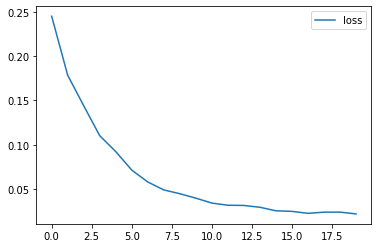

In [9]:
th = model.fit(
    trainX,
    trainTarget,
    epochs=20,
    # steps_per_epoch=1,
    # validation_split=None, 
    verbose=0
)

pd.DataFrame(th.history.get('loss'), columns=['loss']).plot.line()
validPred = model.predict(validX)

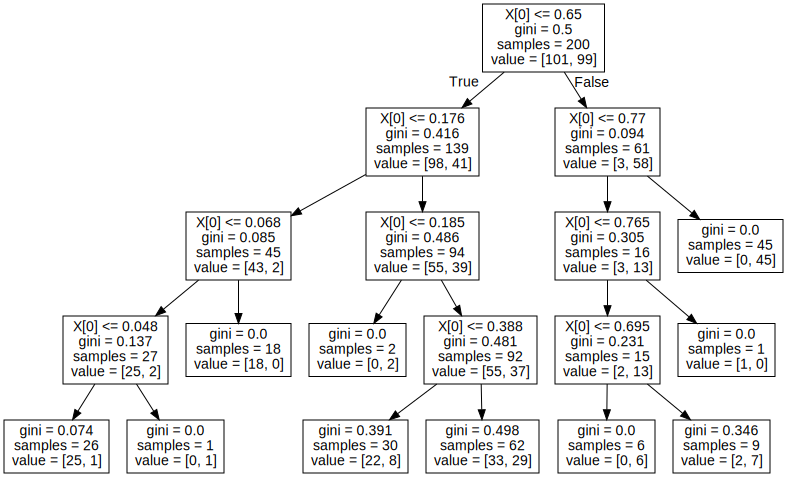

In [10]:
tree = DecisionTreeClassifier(max_depth=4).fit(validPred, validTarget)
# Save Tree
g = graph.Source(export_graphviz(tree))
g
# g.render(filename='tree')

## Evaluating Models

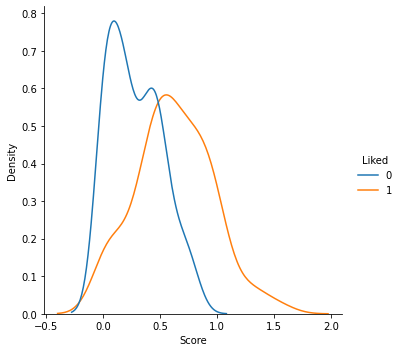

In [11]:
# Neural Network Score
testPred = model.predict(testX)

# Plot Neural Network Score Distribution
z = pd.DataFrame(testPred, columns=['Score'])
z = z.join(testTarget.reset_index())
sns.displot(z, x='Score', hue='Liked', kind='kde')



In [49]:
chart_1 = alt.Chart(z).transform_density(
    density='Score',
    # bandwidth=0.2,
    groupby=['Liked'],
    extent= [-0.5, 2],
    counts = True,
    steps=200,
    as_ = ["Score", "Density"]
).mark_area(line=True, opacity=0.6).encode(
    alt.X('Score:Q'),
    alt.Y('Density:Q', stack=None),
    alt.Color('Liked:N')
).interactive()

chart_2 = alt.Chart(z).mark_bar().encode(
    alt.X('Score', bin=alt.BinParams(step=0.05, extent=[-0.5, 2.0])),
    alt.Y('count()', stack='normalize'),
    color='Liked:N',
    tooltip='count()'
).interactive()

chart_1 | chart_2

alt.HConcatChart(...)

In [12]:
# Neural Networking "Post-Processing"
testPred_Tree = tree.predict(testPred)
testPred_NN = list(map(lambda y: 0 if y < 0.468 else 1, testPred))

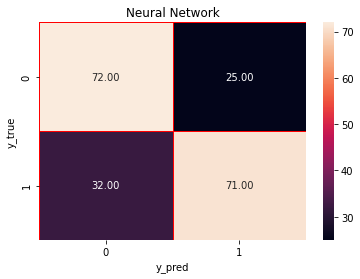

              precision    recall  f1-score   support

           0       0.69      0.74      0.72        97
           1       0.74      0.69      0.71       103

    accuracy                           0.71       200
   macro avg       0.72      0.72      0.71       200
weighted avg       0.72      0.71      0.71       200



array([[72, 25],
       [32, 71]], dtype=int64)

In [14]:
a.evaluate(testTarget, testPred_NN, title='Neural Network')

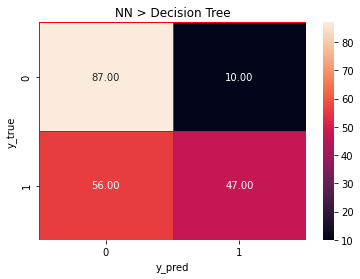

              precision    recall  f1-score   support

           0       0.61      0.90      0.73        97
           1       0.82      0.46      0.59       103

    accuracy                           0.67       200
   macro avg       0.72      0.68      0.66       200
weighted avg       0.72      0.67      0.65       200



array([[87, 10],
       [56, 47]], dtype=int64)

In [15]:
a.evaluate(testTarget, testPred_Tree, title='NN > Decision Tree')